In [2]:
import urllib.request
import json
import pandas as pd
import requests
import math
import shutil
import numpy
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plot
from PIL import Image


# images folder clean
for file in os.listdir('images'):
    path_file = os.path.join('images', file)
    os.remove(path_file)

# Input number of image in Database
img_nbr = input("How many images in Database ? (minimum 100) 'default' = 200")
if img_nbr == "default":
    img_nbr = '200'

url = (
    "https://pixabay.com/api/?key=42732485-b4c1847a3529ea910e8e5fdeb&q=animaux&image_type=photo&per_page="+img_nbr
)
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))
responsedata

def download_image(url):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        image_link = os.path.basename(url)
        filename = os.path.join("./images/", image_link)
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

array = []

for result in responsedata["hits"]:
    array.append(
        (
            result["id"],
            result["tags"],
            result["largeImageURL"],
            result["imageWidth"],
            result["imageHeight"],
            result["imageSize"],
            result["likes"], 
            result["user"],
            result["largeImageURL"].split('.')[-1]
        )
    )

dataframe = pd.DataFrame(array, columns=["id", "tags", "largeImageURL", "imageWidth","imageHeight","imageSize", "likes", "user", "format"])
dataframe = dataframe.astype(
    dtype={"id": "<U200", "tags": "<U200", "largeImageURL": "<U200","imageWidth": "<U200","imageHeight": "<U200","imageSize": "<U200", "likes": "<U200", "user": "<U200", "format": "<U200"}
)
dataframe.largeImageURL.apply(download_image)
dataframe

# Color column
all_images=os.listdir("./images") #list of all the images' names
image_color=[] #list to add the images' color into the dataframe
dataframe['color']='None'
colorsOfAllImages=[] 
for i in range(len(all_images)):
    colorsOfOneImage="" #Reinitialization of the value of the colors
    color = [] #most significant colors of the images
    imgfile = Image.open("./images/"+all_images[i])
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if numarray.ndim == 1:
        imgfile = imgfile.convert('RGB')
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = KMeans(n_clusters=4, n_init=2)
    clusters.fit(numarray)
    npbins = numpy.arange(0, 5)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    for i in range(4):
        image_color=[math.ceil(clusters.cluster_centers_[i][0]),math.ceil(clusters.cluster_centers_[i][1]),math.ceil(clusters.cluster_centers_[i][2])]
        # Categorization
        for j in range(3):
            image_color[j] -= (image_color[j]) % 32
        color.append(image_color)
    colorsOfAllImages.append(color)
dataframe.loc[:,'color']=colorsOfAllImages

# Data type conversion to sort
for int_column in ["id","imageWidth","imageHeight","imageSize","likes"]:
    dataframe[int_column] = dataframe[int_column].astype(int)

# imageSize Categorization
dataframe["imageSize"] -= dataframe["imageSize"] % 500000 
for i in range(len(dataframe["imageSize"])):
    if dataframe.loc[i, "imageSize"] > 2000000:
        dataframe.loc[i, "imageSize"] = 2000000


# Json conversion, Storage
json_data = dataframe.to_json(orient='records', indent = 4)
file_path = "data.json"
with open(file_path, "w") as json_file:
    json_file.write(json_data)

# Read test for the json produced
readtest_data = json.load(open("data.json"))
readtest_dataframe = pd.json_normalize(readtest_data)
readtest_dataframe


 

C:\Users\guill\AppData\Local\Temp\ipykernel_23816\1546833930.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,id,tags,largeImageURL,imageWidth,imageHeight,imageSize,likes,user,format,color
0,715588,"fox, nature, animals",https://pixabay.com/get/g2f441c726db346851abca...,3595,2414,2000000,1513,AlainAudet,jpg,"[[192, 192, 192], [0, 0, 0], [128, 96, 96], [1..."
1,430441,"horses, galloping, running",https://pixabay.com/get/gb1ab3337dc7b4399b618b...,4500,3000,1000000,1522,SorcerySoapHP,jpg,"[[64, 32, 32], [128, 128, 64], [192, 192, 192]..."
2,591359,"tigers, cub, snow",https://pixabay.com/get/gd2b36d39ecaca117e5b95...,4342,2798,2000000,1746,Sponchia,jpg,"[[32, 32, 0], [224, 192, 192], [160, 160, 128]..."
3,2904536,"horses, pair, wild horses",https://pixabay.com/get/gd856e54d15049cc6abb4a...,4000,3000,2000000,1590,susannp4,jpg,"[[32, 32, 0], [0, 0, 0], [96, 96, 96], [64, 64..."
4,2934720,"cat, kitten, pets",https://pixabay.com/get/ga61bc686a1f3ba5e317e8...,3495,2330,1500000,1549,Kirgiz03,jpg,"[[128, 64, 32], [96, 96, 64], [64, 32, 0], [16..."
...,...,...,...,...,...,...,...,...,...,...
95,2222908,"giraffe, head, ossicones",https://pixabay.com/get/g97ab5a10b609aebfedf3a...,4000,2669,2000000,690,Alexas_Fotos,jpg,"[[64, 64, 64], [32, 32, 0], [128, 96, 32], [12..."
96,2045655,"eagle, portrait, wild",https://pixabay.com/get/g04224076073f5659c7b03...,2066,2426,1000000,852,Robert_C,jpg,"[[96, 128, 128], [32, 32, 32], [192, 192, 192]..."
97,1341881,"wolves, forest, wintry",https://pixabay.com/get/g8609bbc461f0dd7b7c2fb...,4096,2160,1000000,3164,51581,jpg,"[[0, 0, 0], [192, 160, 128], [128, 96, 64], [6..."
98,1869337,"dolphins, mammals, animals",https://pixabay.com/get/g4a7b7644d5b805d609400...,3840,2160,500000,388,Pexels,jpg,"[[96, 96, 96], [64, 64, 32], [0, 0, 0], [160, ..."


On va stocker id, tags, largeImageURL, imageWidth, imageHeight, imageSize, likes, format de l'image en prenant ce qu'il y a après le .; user

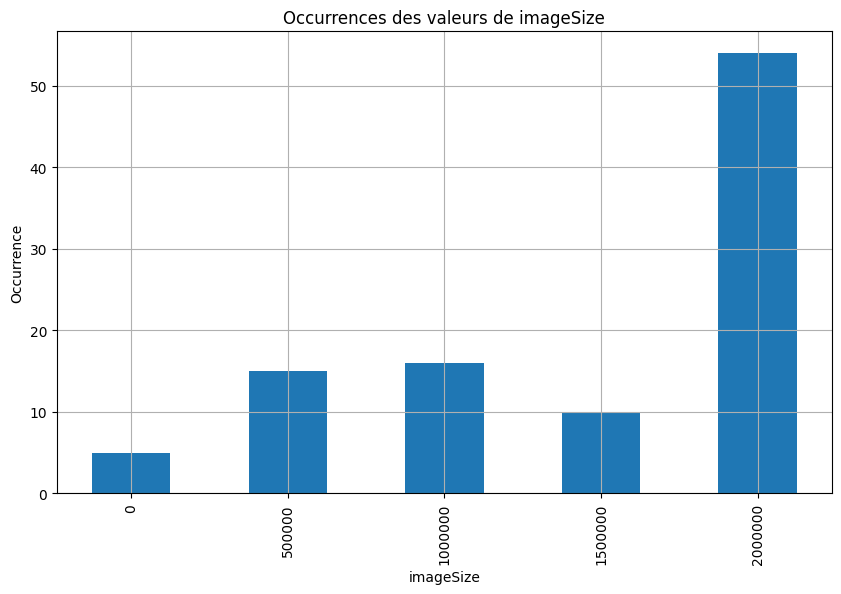

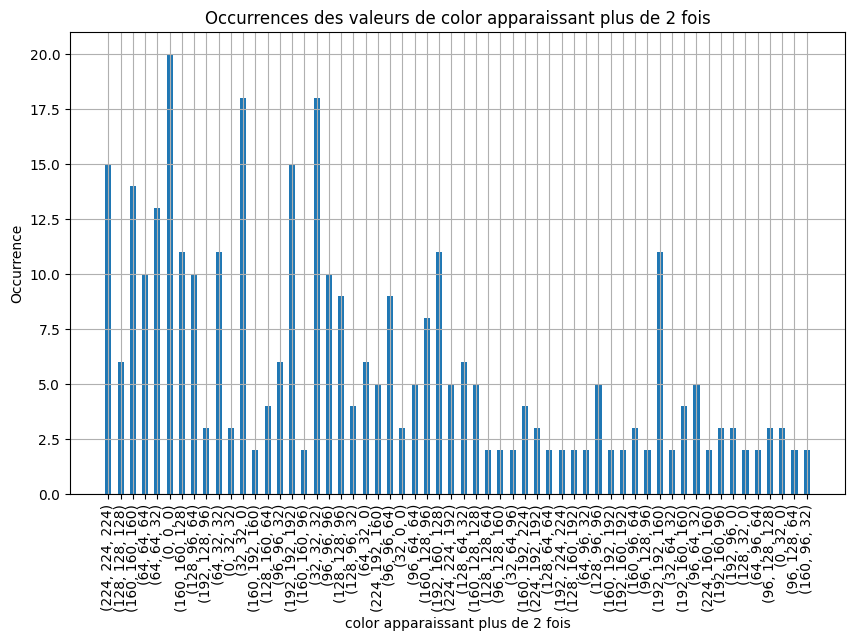

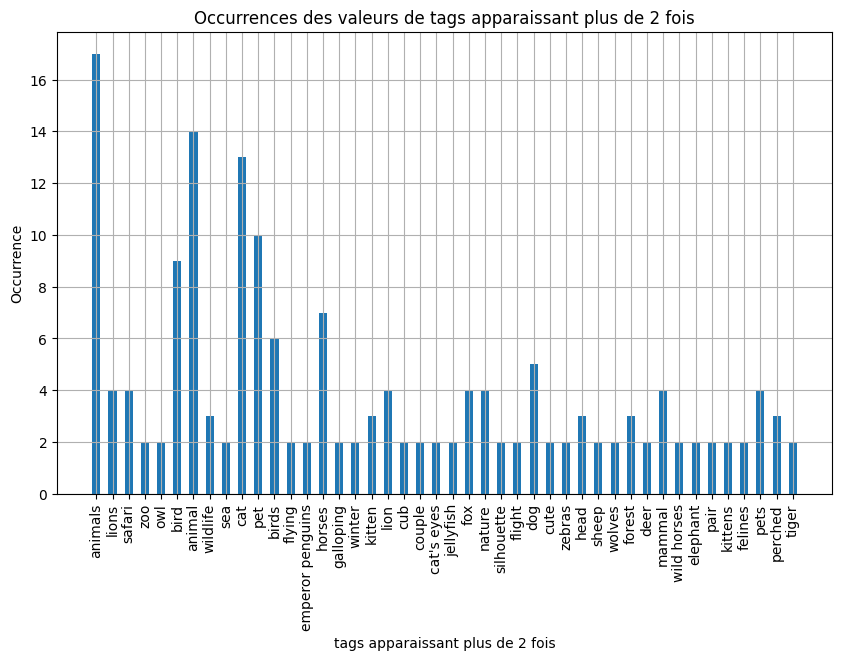

In [3]:
# Loads json
data = json.load(open("data.json"))
dataframe = pd.json_normalize(data)

# Sort
sort_key = input("Sort by : \n id / imageWidth / imageHeight / imageSize / color / likes ")
dataframe = dataframe.sort_values(by=sort_key)
dataframe
# Json conversion, Storage
json_data = dataframe.to_json(orient='records', indent = 4)
file_path = "data.json"
with open(file_path, "w") as json_file:
    json_file.write(json_data)



# Occurrences
def occurrences(column, isColor = False, isTags = False):
    res = {}
    for value in dataframe[column]:
        if isinstance(value, list): # List case
            for element in value:
                if isColor : # color case
                    element = tuple(element)
                if element in res:
                    res[element] += 1
                else:
                    res[element] = 1
                    
        else: # Single element case
            if isTags: # tags case
                value = value.split(', ')
                for i in value:
                    if i in res:
                        res[i] += 1
                    else:
                        res[i] = 1
            else : 
                if value in res:
                    res[value] += 1
                else:
                    res[value] = 1
    return res
        

def visu_plot(name, data, bar_width=0.5):
    plot.figure(figsize=(10, 6))  # Taille de la figure

    keys = [str(key) for key in data.keys()]
    #keys = list(data.keys())
    values = list(data.values())
    plot.bar(keys, values, width=bar_width)

    # Ajout de titre et de labels
    plot.title('Occurrences des valeurs de ' + name)
    plot.xlabel(name)
    plot.xticks(rotation=90)
    plot.ylabel('Occurrence')

    # Affichage du graphique
    plot.grid(True)  # Afficher la grille
    plot.show()



visu_plot("imageSize",dict(sorted(occurrences("imageSize").items())))

reduced_color_occurrences = {key: value for key, value in occurrences("color",True).items() if value > 1}
visu_plot("color apparaissant plus de 2 fois",reduced_color_occurrences)

reduced_tag_occurrences = {key: value for key, value in occurrences("tags",False,True).items() if value > 1}
visu_plot("tags apparaissant plus de 2 fois",reduced_tag_occurrences)


In [16]:
from random import randint
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk

def count_favorites(list):
    count = 0
    for value in list:
        count += (value == "favorite")
    return count

# Fonction pour afficher l'image correspondant à l'index actuel
def show_image():
    global dataframe, label
    
    # Vérifier si le nombre de favoris atteint 10
    if count_favorites(preference) >= 10:
        root.destroy()  # Fermer la fenêtre Tkinter
    else:        
        # Effacer l'image actuelle
        label.config(image=None)
        
        # Obtenir le chemin d'accès de l'image
        rand = randint(0,99)
        image_path = "./images/" + dataframe.iloc[rand]["largeImageURL"].split("/")[-1]
        stockage=dataframe.iloc[rand]["tags"].split(",")
        stockage.append(dataframe.iloc[rand]["imageSize"])
        stockage.append(dataframe.iloc[rand]["color"][1])
        datas.append(stockage)
        
        # Tentative d'ouverture de l'image
        try:
            image = Image.open(image_path)
            photo = ImageTk.PhotoImage(image)
            # Afficher l'image dans le label
            label.config(image=photo)
            label.image = photo
            # Créer une fenêtre pour que l'utilisateur puisse soumettre son choix
            create_choice_window()
        except Exception as e:
            print("Erreur lors de l'ouverture de l'image :", str(e))  # Afficher l'erreur


# Fonction pour passer à la photo suivante
def show_next_image(event=None):
    if event.char == "y":
        preference.append("favorite")
        close_choice_window()
        show_image()
            
    if event.char == "n":
        preference.append("not favorite")
        close_choice_window()
        show_image()


# Créer une fenêtre pour que l'utilisateur puisse soumettre son choix
def create_choice_window():
    global choice_window
    
    choice_window = tk.Toplevel()
    choice_window.title("Aimez-vous cette image ?")
    choice_window.geometry("350x50")  # Définit la taille de la fenêtre
    message_label = tk.Label(choice_window, text="veuillez appuyer sur une touche : \n'y' -> yes\n'n' -> no")
    message_label.pack()
    
# Fonction pour fermer la fenêtre de choix
def close_choice_window():
    global choice_window
    if choice_window:
        choice_window.destroy()


datas=[]
preference=[]

# Création de la fenêtre principale Tkinter
root = tk.Tk()
root.title("Image Viewer")

# Création du label pour afficher l'image
label = ttk.Label(root)
label.pack()

# Liage de l'événement de pression de touche "n" à la fonction show_next_image
root.bind("<Key>", show_next_image)

# Afficher la première image
show_image()

# Exécution de la fenêtre Tkinter
root.mainloop()

# Afficher les préférences enregistrées
print("Préférences :", datas)

    

Chemin d'accès de l'image : ./images/gee851065f0f812824b5f54bf7c9540ba6c15034fd5e7b84109fcd0b05a17ec782eb73da617196b59b9478332e4c99b65881f43449ed3e2322c75baca1aef50cf_1280.jpg
Chemin d'accès de l'image : ./images/gaa2df2265ab6c9b26c1f508fb5d794a3dc430c7b13ec6ebd651448d78ade730c86f3dd6b7b89877bcaeafc78b3c7c76a070c2f32ddc520e292ddf9f3bf5aeda4_1280.jpg
Chemin d'accès de l'image : ./images/g6b4b972cbc1afec1bb29555722a14262dff860192cc508c2d80fa29e0f52786973fdf279f8dbbb4ac6e723c5b8fddd0e5a47e7e0f9bf81a2e0e017c9ba23313a_1280.jpg
Chemin d'accès de l'image : ./images/g0ac15b7655535042f8e825592fbaed208d7b02412608ec08ad6cd34124c230ad9ea35c8dfff0d5f4bec873ea77afbbe4ca64e27a133c65ec4bb9eb370bdbec78_1280.jpg
Chemin d'accès de l'image : ./images/g7cc35c3e11a7abb3a09b8384bb04264a24be6851391ffe6ea9111ae94e81171521455a93a58fb4cb63bb878700046a7d019c88ae142af82d5af91b8828b85154_1280.jpg
Chemin d'accès de l'image : ./images/gdd6d2f47de0d6fdc7f56a3c4d8ad2a3b19905b4a349feac4c2d6304b52ca7bdac58e180ace26a2d18f

'\nfrom PIL import Image\nimport numpy\nimport math\nimport matplotlib.pyplot as plot\nfrom sklearn.cluster import KMeans\n\nimgfile = Image.open("./images/g0a7d390874e92d7c4ae52f9845f6f31c19f5d286c89df292b17030ca937cf1c20834db6a0a10087c44beede67fe3282d25ef085d23f5efef5bc98417707299be_1280.jpg")\nnumarray = numpy.array(imgfile.getdata(), numpy.uint8)\nclusters = KMeans(n_clusters=4, n_init=2)\nclusters.fit(numarray)\nnpbins = numpy.arange(0, 5)\nhistogram = numpy.histogram(clusters.labels_, bins=npbins)\nlabels = numpy.unique(clusters.labels_)\nbarlist = plot.bar(labels, histogram[0])\nfor i in range(4):\n    barlist[i].set_color(\n        "#%02x%02x%02x"\n        % (\n            math.ceil(clusters.cluster_centers_[i][0]),\n            math.ceil(clusters.cluster_centers_[i][1]),\n            math.ceil(clusters.cluster_centers_[i][2]),\n        )\n    )\nplot.show()'

16
16
Accuracy: 1.0


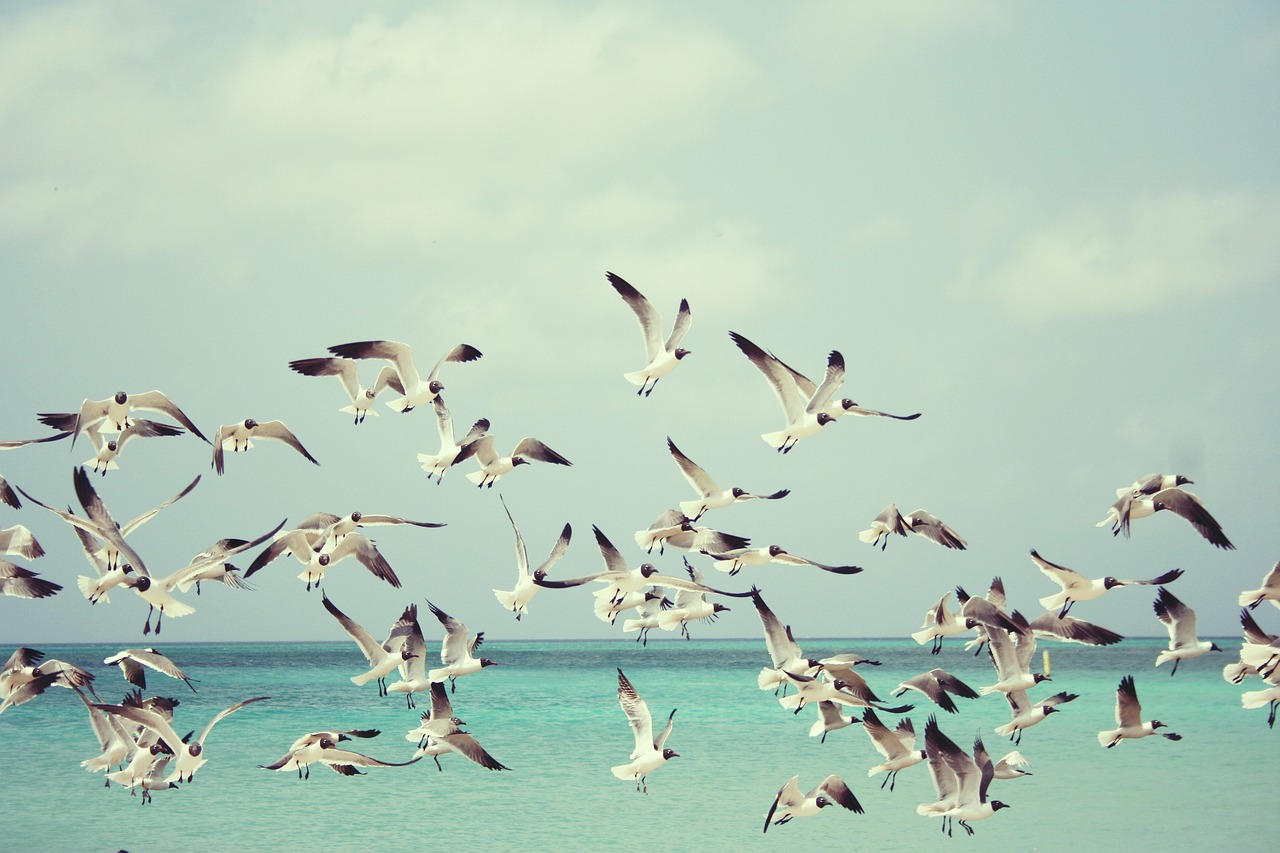

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

tags = dataframe.iloc[:]["tags"]
liste_tags = [] #Une liste avec tous les tags
for i in tags:
    liste = i.split(', ')
    liste_inte = []
    for j in liste:
        liste_inte.append(j)
    liste_tags.append(liste_inte) 

tailleImage = dataframe.iloc[:]["imageSize"] 
couleur = dataframe.iloc[:]["color"]

for i in range (len(liste_tags)):
    liste_tags[i].append(tailleImage[i]) #On ajoute toutes les tailles des images 
    liste_tags[i].append(couleur[i][0][0])
    liste_tags[i].append(couleur[i][0][1])
    liste_tags[i].append(couleur[i][0][2]) #On ajoute les couleurs une par une à notre liste

result=[]

for i in range(len(liste_tags)):
    result.append("not favorite")
    liste = liste_tags[i]
    for n in range(4): #On prend les 4 premiers élements de notre liste de caractérisations, nos tags et notre taille
        for j in range(len(datas)):
            for k in range(len(datas[j])-1):
                if datas[j][k] == liste[n]:
                    result[i] = preference[j] #Puis on vérifie si ce tag appartient aux images testées précédemment et on lui affecte ce que l'utilisateur à renseigner comme choix
    
    for n in range(4,len(liste)):
        for j in range(len(datas)):
             if n in datas[j][4]: #On vérifie ensuite que notre couleur est dans la liste des couleurs 
                 result[i] = preference[j] #Puis on applique la préférence de l'utilisateur

# Encode categorical features and labels
label_encoders = [LabelEncoder() for _ in range(len(liste_tags[0]))] #Encodage des valeurs
encoded_data = []
for i, column in enumerate(zip(*liste_tags)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = result  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
prediction = 'not favorite'
while (prediction == 'not favorite'): #On tire une image aléatoire jusqu'à ce que ce que l'algorithme de classification estime que l'utilisateur va aimer cette image
    rand = randint(0,99)
    sample_item = dataframe.iloc[rand]["tags"].split(", ") 
    tailleSample = dataframe.iloc[rand]["imageSize"]
    colorSample = dataframe.iloc[rand]["color"][0]
    sample_item.append(tailleSample)
    sample_item.append(colorSample[0])
    sample_item.append(colorSample[1])
    sample_item.append(colorSample[2])
    #print(sample_item) # Sample item attributes
    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    #print(f"Prediction for the sample item: {prediction}")
    
image = dataframe.iloc[rand]["largeImageURL"].split("/")[-1] #On affiche l'image que l'algorithme recommande
path = "./images/" + image
images= Image.open(path) 
display(images)



[['lions', ' animals', ' nature', 2000000, [32, 0, 0]], ['jellyfish', ' animal', ' underwater', 0, [32, 160, 224]], ['wolves', ' wolf pack', ' forest', 2000000, [0, 64, 224]], ['pile', ' animals', ' fairy tale', 2000000, [160, 96, 96]], ['kittens', ' pet', ' felines', 2000000, [128, 64, 32]], ['cat', ' kitten', ' pets', 1500000, [96, 96, 64]], ['chicken', ' rooster', ' hen', 2000000, [160, 160, 96]], ['pets', ' cat', ' pet', 1000000, [128, 96, 32]], ['chickens', ' birds', ' nature', 2000000, [96, 64, 64]], ['cows', ' cattle', ' grazing', 2000000, [192, 192, 192]]]


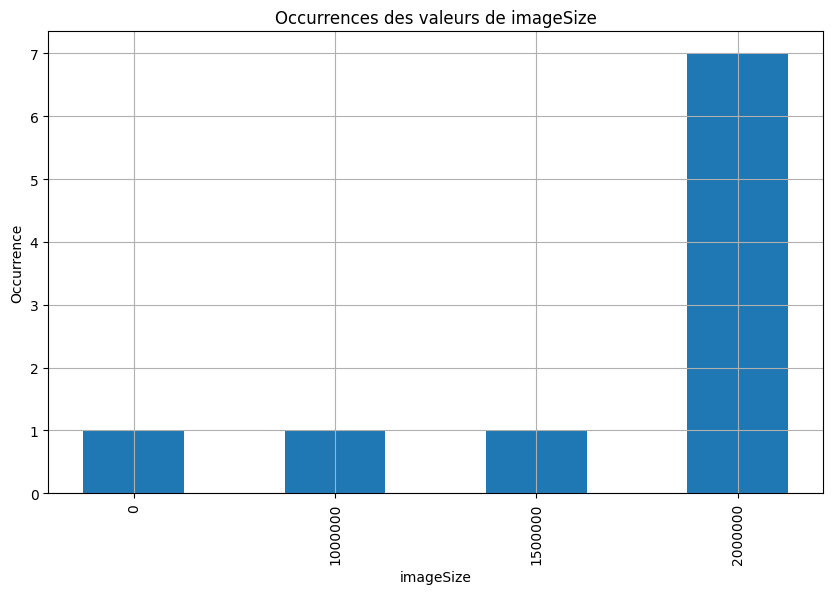

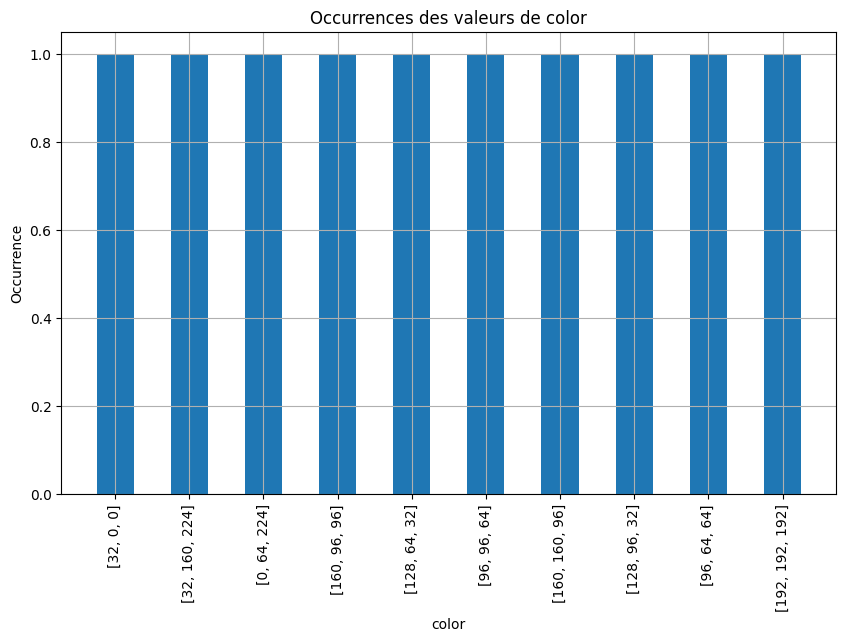

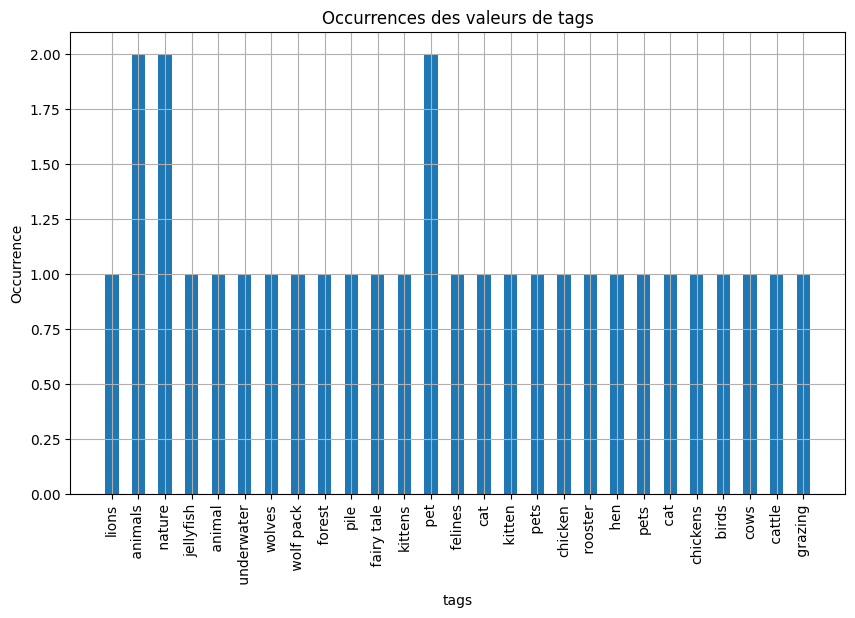

In [9]:

# Preferences Visualisation
favorites = []
for i in range(len(preference)):
    if preference[i] == "favorite" :
        favorites.append(datas[i])
print(favorites)

favorites_tags_occurences = {}
favorites_imageSize_occurences = {}
favorites_color_occurences = {}
for element in favorites:
    for i in range(3): # tags
        if element[i] in favorites_tags_occurences:
            favorites_tags_occurences[element[i]] += 1
        else:
            favorites_tags_occurences[element[i]] = 1
    # imageSize
    if element[3] in favorites_imageSize_occurences:
        favorites_imageSize_occurences[element[3]] += 1
    else:
        favorites_imageSize_occurences[element[3]] = 1
    # color
    fav_color = str(element[4])
    if fav_color in favorites_color_occurences:
        favorites_color_occurences[fav_color] += 1
    else:
        favorites_color_occurences[fav_color] = 1
    


visu_plot("imageSize",dict(sorted(favorites_imageSize_occurences.items())))
visu_plot("color",favorites_color_occurences)
visu_plot("tags",favorites_tags_occurences)

Accuracy: 0.6666666666666666
Prediction for the sample item: Favorite
